In [1]:
# Imports
import torch
torch.cuda.empty_cache()

from utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict, TypeAlias

ArrList: TypeAlias = List[np.ndarray]

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = get_input_transform(520, IMG_SIZE)

In [2]:
from high_res import HighResDV2

shifts = [1, 2, 3, 4, 5, 6, 7]
net = HighResDV2("dinov2_vits14", shifts, pattern="Moore", dtype=torch.float32, pca_each=False)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [32]:
def get_fg_features_and_masks(img_paths: List[str], thresholds: List[Tuple[bool, int]], low_res: bool=True) -> List[ArrList]:
    out: List[List[np.ndarray]] = []
    for i, path in enumerate(img_paths):
        img_arrs: List[np.ndarray] = []
        tensor, img = load_image(path, transform)
        c, h, w = tensor.shape
        tensor = tensor.cuda()

        feat_hr, feat_lr = net(tensor)
        feat_hr_arr, feat_lr_arr = to_numpy(feat_hr), to_numpy(feat_lr)
        feat_hr_flat = flatten(feat_hr_arr, h, w, net.feat_dim)

        if low_res:
            pca_lr = do_single_pca(feat_lr_arr)
        pca_hr = do_single_pca(feat_hr_flat)

        gt, t = thresholds[i]
        fg_feat_hr, _, fg_mask_hr = threshold_pca(feat_hr_flat, pca_hr, t, gt, True)
        if low_res:
            fg_feat_lr, _, fg_mask_lr = threshold_pca(feat_lr_arr, pca_lr, t, gt, True)
            img_arrs = [fg_feat_hr, fg_mask_hr, fg_feat_lr, fg_mask_lr, img]
        else:
            img_arrs = [fg_feat_hr, fg_mask_hr, img]
        out.append(img_arrs)
    return out

def do_shared_pca(feat_list: ArrList, k: int=3) -> ArrList:
    concat_features = np.concatenate(feat_list, 0)
    shared_pca = PCA(n_components=k)
    shared_pca.fit(concat_features)
    out: List[np.ndarray] = []
    for feat in feat_list:
        shared_repr = shared_pca.transform(feat)
        out.append(shared_repr)
    return out

def pca_and_mask_to_arr(pca: np.ndarray, mask: np.ndarray, h: int, w: int, reshape: bool=True) -> np.ndarray:
    c = pca.shape[-1]
    out = np.zeros((h * w, c))
    nonzero_idx = 0
    for j, val in enumerate(mask):
        if val == 1:
            out[j, :] = pca[nonzero_idx, :]
            nonzero_idx += 1
    if reshape:
        out = out.reshape((h, w, c))
    return out

def plot_shared_pcas(pcas_hr: ArrList, masks_hr: ArrList, pcas_lr: ArrList, masks_lr: ArrList, imgs: List[Image.Image]) -> None:
    N_imgs = len(pcas_hr)
    fig, axs = plt.subplots(N_imgs, 3)
    fig.set_size_inches(16, 20)
    for i in range(N_imgs):
        
        norm_pca_hr = rescale_pca(pcas_hr[i])
        norm_pca_lr = rescale_pca(pcas_lr[i])
        mask_hr = masks_hr[i]
        mask_lr = masks_lr[i]
        img = imgs[i]
        h, w = img.height, img.width

        out_hr = pca_and_mask_to_arr(norm_pca_hr, mask_hr, h, w)
        out_lr = pca_and_mask_to_arr(norm_pca_lr, mask_lr, PATCH_H, PATCH_W)

        if i == 0:
            axs[i, 0].set_title("Original", fontsize=24)
            axs[i, 1].set_title("DINOv2", fontsize=24)
            axs[i, 2].set_title("HR-Dv2", fontsize=24)
        
        axs[i, 0].imshow(imgs[i])
        axs[i, 0].set_axis_off()
        axs[i, 1].imshow(out_lr)
        axs[i, 1].set_axis_off()
        axs[i, 2].imshow(out_hr)
        axs[i, 2].set_axis_off()
    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.savefig("out/shared_pca.png")

In [30]:
def threshold_pca_plot(img_paths: List[str], thresholds: List[Tuple[bool, int]]) -> None:
    print("Computing foreground features")
    feat_mask_list = get_fg_features_and_masks(img_paths, thresholds)
    pcas_hr, masks_hr, pcas_lr, masks_lr, imgs = [], [], [], [], []
    for i in feat_mask_list:
        pcas_hr.append(i[0])
        masks_hr.append(i[1])
        pcas_lr.append(i[2])
        masks_lr.append(i[3])
        imgs.append(i[4])
    print("Computing shared PCAs")
    shared_pcas_hr, shared_pcas_lr = do_shared_pca(pcas_hr), do_shared_pca(pcas_lr)
    print("Plotting")
    plot_shared_pcas(shared_pcas_hr, masks_hr, shared_pcas_lr, masks_lr, imgs)
    plt.show()

Computing foreground features
Computing shared PCAs
Plotting


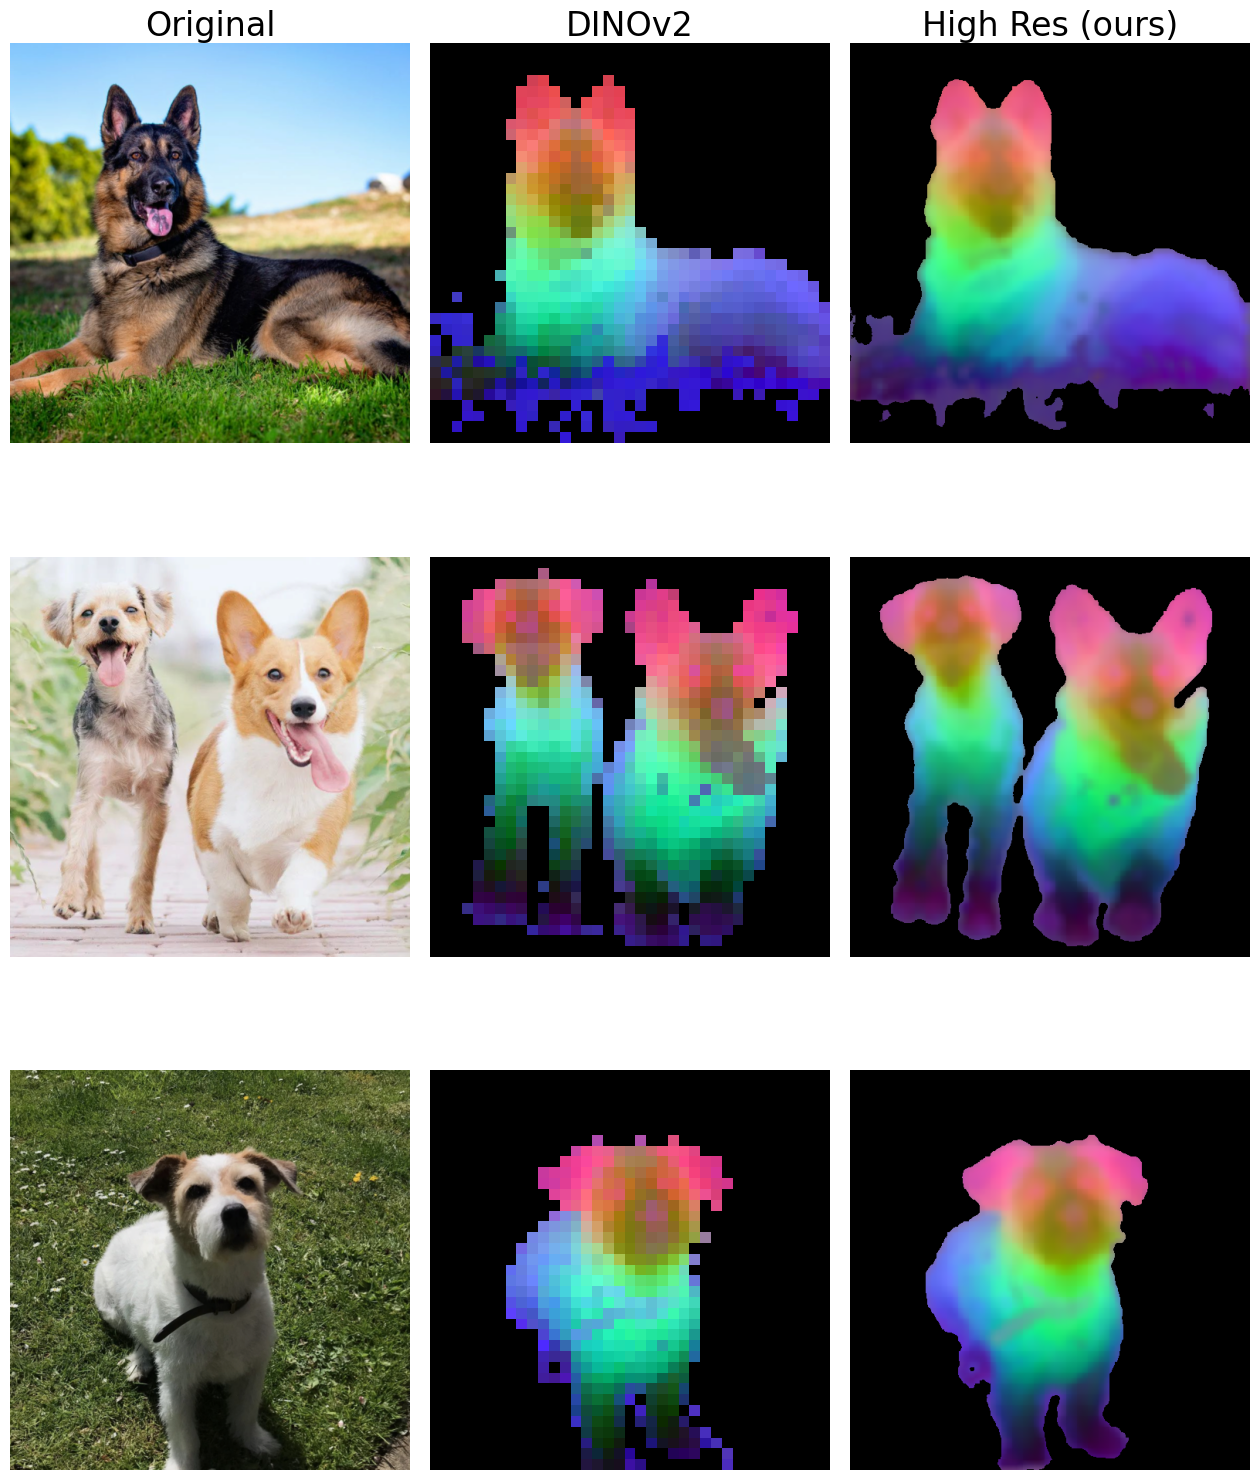

In [33]:
dog_paths = [f"data/d{i}.jpg" for i in range(1, 4)]
dog_thresholds = ((False, -0.1), (False, 0), (True, 0.4)) 
threshold_pca_plot(dog_paths, dog_thresholds)

Computing foreground features
Computing shared PCAs
Plotting


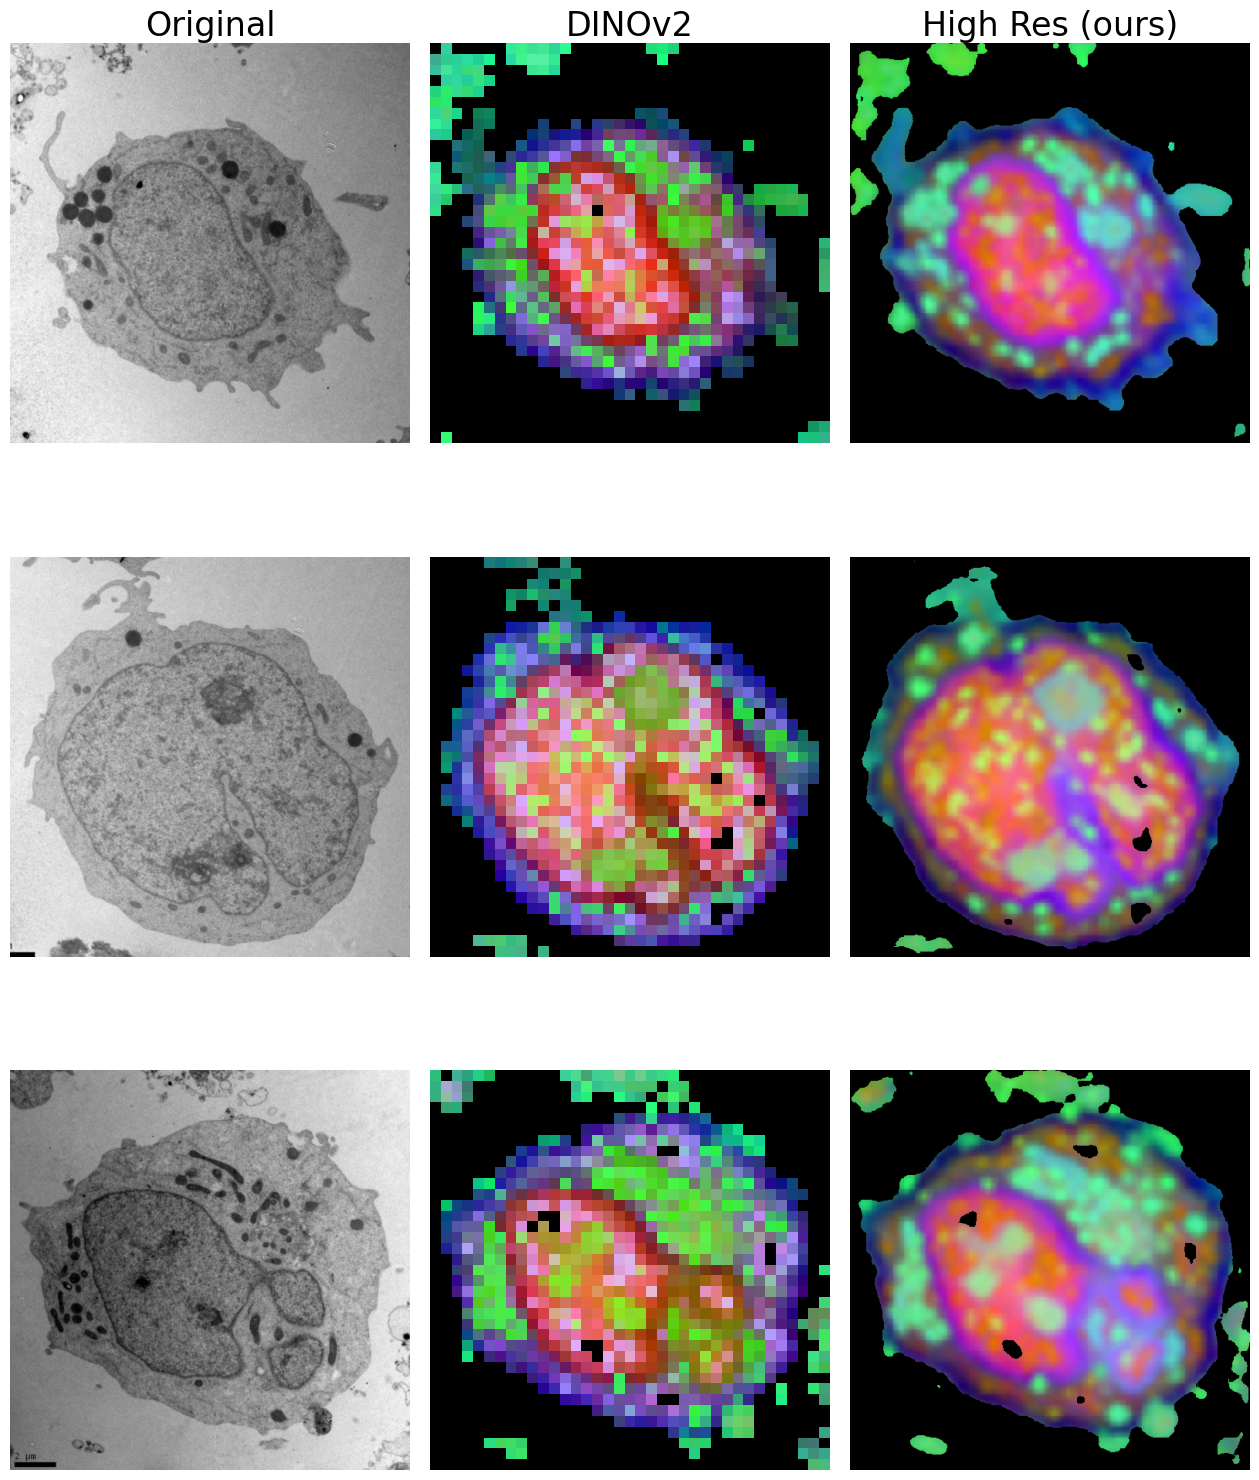

In [36]:
cell_paths = [f"data/c{i}.jpg" for i in range(1, 4)]
cell_thresholds = ((False, 0), (False, 0.1), (False, 0.1)) 
threshold_pca_plot(cell_paths, cell_thresholds)